<h2>Step 1: Load Dataset</h2>

In [1]:
#load important libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#load dataset from NumPy array files
X_train = np.load('./Dataset/X_train.npy')
Y_train = np.load('./Dataset/Y_train.npy')
X_test = np.load('./Dataset/X_test.npy')
Y_test = np.load('./Dataset/Y_test.npy')

In [3]:
#determine shapes of loaded arrays
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((57266, 28, 28), (57266,), (3015, 28, 28), (3015,))

In [4]:
#select random image array index to show
train_index = 1185               # should be < 57266
test_index = 1011                # should be < 3015

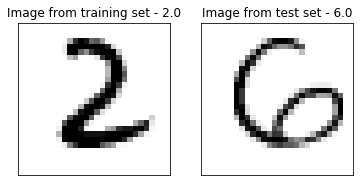

In [5]:
#show image & label for given train_index, test index
fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2)
ax1.imshow(X_train[train_index]).set_cmap("gray")
ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])
ax1.set_title("Image from training set - "+str(Y_train[train_index]))

ax2.imshow(X_test[test_index]).set_cmap("gray")
ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])
ax2.set_title("Image from test set - "+str(Y_test[test_index]))
print(end="")

<h2>Step 2: Create convolutional Layer</h2>

In [6]:
def convolutionLayer(image, imageFilters, biases, stride=[1,1]):
    
    #assume 'valid' padding
    padding = 0
        
    #get dimensions of image
    heightImage = image.shape[0]
    widthImage = image.shape[1]
    channelImage = 1
    if(len(image.shape)>2):
        channelImage = image.shape[2]
        
    #get dimensions of imageFilters
    numberImageFilters = imageFilters.shape[0]
    heightImageFilters = imageFilters.shape[1]
    widthImageFilters = imageFilters.shape[2]
    channelImageFilters = 1
    if(len(imageFilters.shape)>3):
        channelImageFilters = imageFilters.shape[3]

    #check if (No. of channels in image == imageFilters depth) && (imageFilters.length == imageFilters.breadth)
    if( (channelImage == channelImageFilters) and (heightImageFilters==widthImageFilters) ):
        #init output
        heightOutputImage = int((heightImage+2*padding-heightImageFilters)/stride[0] + 1)
        widthOutputImage = int((widthImage+2*padding-widthImageFilters)/stride[1] + 1)
        results = np.zeros([heightOutputImage, widthOutputImage, numberImageFilters,], dtype=float)
        
        #iterate through each filter
        for k in range(numberImageFilters):
            currentImageFilter = imageFilters[k, :]
            #iterate through all possible locations where filter can be placed
            #create temp variable to store row_count in results
            iprime = 0
            for i in range(0, heightImage-heightImageFilters+1, stride[0]):
                #create temp variable to store col_count in results
                jprime = 0    
                for j in range(0, widthImage-widthImageFilters+1, stride[1]):
                    #get sum of (elementwise product of image and currentImageFilter at current location)
                    if (channelImage == 1):
                        results[iprime][jprime][k] = np.sum(np.multiply(image[i:i+heightImageFilters, j:j+widthImageFilters], currentImageFilter)) + biases[k]

                    else:
                        results[iprime][jprime][k] = np.sum(np.multiply(image[i:i+heightImageFilters, j:j+widthImageFilters, :], currentImageFilter)) +biases[k]
                    #increment temp col_count
                    jprime = jprime + 1
                #increment temp row_count
                iprime = iprime + 1
        return results  

In [34]:
#create temporary image & imageFilter for demo
image = np.array(
    [[[1,1,1],[2,2,2],[3,3,3],[4,4,4]],
     [[5,5,5],[6,6,6],[7,7,7],[8,8,8]],
     [[9,9,9],[10,10,10],[11,11,11],[12,12,12]],
     [[13,13,13],[14,14,14],[15,15,15],[16,16,16]]])

imageFilters = np.array([
    [[[1,1,1],[0,0,0],[-1,-1,-1]],
     [[1,1,1],[0,0,0],[-1,-1,-1]],
     [[1,1,1],[0,0,0],[-1,-1,-1]]],
    [[[-1,-1,-1],[-1,-1,-1],[-1,-1,-1]],
     [[0,0,0],[0,0,0],[0,0,0]],
     [[1,1,1],[1,1,1],[1,1,1]]]
    ])

biases = np.array([0, -1000.2])

print(image.shape)
print(imageFilters.shape)
print(biases.shape)

(4, 4, 3)
(2, 3, 3, 3)
(2,)


In [35]:
#run demo to show function is working
convolutionLayer(image, imageFilters, biases)

array([[[ -18. , -928.2],
        [ -18. , -928.2]],

       [[ -18. , -928.2],
        [ -18. , -928.2]]])

In [36]:
#create 1 channel filters
filterImg = np.array([[ [-1,-1,-1],
                       [ 0, 0, 0],
                       [ 1, 1, 1]],
                       [[1,0,-1],
                        [1,0,-1],
                        [1,0,-1]]])
print(filterImg.shape)

(2, 3, 3)


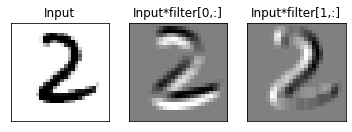

In [37]:
#visualizing convolution with 1 channel filters
fig1,(ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3)
ax1.imshow(X_train[train_index]).set_cmap("gray")
ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])
ax1.set_title("Input")

ax2.imshow(convolutionLayer(X_train[train_index], filterImg, biases)[:, :, 0]).set_cmap("gray")
ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])
ax2.set_title("Input*filter[0,:]")

ax3.imshow(convolutionLayer(X_train[train_index], filterImg, biases)[:, :, 1]).set_cmap("gray")
ax3.get_xaxis().set_ticks([])
ax3.get_yaxis().set_ticks([])
ax3.set_title("Input*filter[1,:]")
print(end="")

<h2>Step 3: Create Max Pooling Layer </h2>

In [11]:
def maxPoolingLayer(image, size=[2,2], stride=[2,2]):
    
        #get dimensions of image
        heightImage = image.shape[0]
        widthImage = image.shape[1]
        
        #init output
        heightOutputImage = int((image.shape[0]-size[0])/stride[0]+1)
        widthOutputImage = int((image.shape[1]-size[1])/stride[1]+1)
        channelOutputImage = image.shape[-1]
        results = np.zeros([heightOutputImage, widthOutputImage, channelOutputImage], dtype=float)
        #do for each map(channel) in image
        for channel in range(channelOutputImage):
            #create temp variable to store row_count in results
            iprime = 0
            #do for each row in stride[0] steps
            for i in range(0, heightImage-size[0]+1, stride[0]):
                #create temp variable to store col_count in results
                jprime = 0
                #do for each col in in stride[1] steps
                for j in range(0, widthImage-size[1]+1, stride[1]):
                    results[iprime, jprime, channel] = np.max(image[i:i+size[0], j:j+size[1], channel])
                    #increment temp col_count
                    jprime = jprime + 1
                #increment temp row_count
                iprime = iprime + 1
                
        return results

In [12]:
#run demo to show function is working
maxPoolingLayer(image)

array([[[ 6.,  6.,  6.],
        [ 8.,  8.,  8.]],

       [[14., 14., 14.],
        [16., 16., 16.]]])

<h2>Step 4: Create ReLU Layer </h2>

In [13]:
def relu(feature_map):
    #take elementwise maximum between feature_map and zero
    return np.maximum(feature_map, 0)

In [14]:
#create random feature array
np.random.seed(0)  #set seed to generate same filter everytime code is executed
feature = np.random.randn(3,3)
print(feature)

[[ 1.76405235  0.40015721  0.97873798]
 [ 2.2408932   1.86755799 -0.97727788]
 [ 0.95008842 -0.15135721 -0.10321885]]


In [15]:
#run demo to show function is working
relu(feature)

array([[1.76405235, 0.40015721, 0.97873798],
       [2.2408932 , 1.86755799, 0.        ],
       [0.95008842, 0.        , 0.        ]])

<h2>Step 5: Define Sigmoid activation function </h2>

In [16]:
def sigmoid(X):
    out = np.exp(X)
    return out/np.sum(out)

In [17]:
#create random feature array
np.random.seed(1)  #set seed to generate same feature array everytime code is executed
feature = np.random.randn(5)
print(feature)

[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]


In [18]:
#run demo to show function is working
sigmoid(feature)

array([0.56862917, 0.06077185, 0.06606977, 0.0383178 , 0.26621141])

<h2>Step 6: Define cross entropy loss function </h2>

In [19]:
def crossEntropy(probs, label):
    return -np.sum(label * np.log(probs))

In [20]:
#create random label and probs array
labels = [1, 0, 0, 0, 0]
probs = [0.1, 0.5, 0.1, 0.1, 0.2]

In [21]:
#run demo to show function is working
crossEntropy(probs, labels)

2.3025850929940455